=== DEEP CLUSTERING PROJECT (CAE vs VAE) ===

=== LOADING CIFAR-10 DATA ===

VAE/Flat data shape: (5000, 32, 32, 3)
CAE data shape: (5000, 32, 32, 3)
Number of classes: 10

=== TRADITIONAL CLUSTERING METHODS ===

K-Means Results:
  Adjusted Rand Index: 0.035
  Normalized Mutual Info: 0.072
  Silhouette Score: 0.045

PCA + K-Means Results:
  Adjusted Rand Index: 0.034
  Normalized Mutual Info: 0.070
  Silhouette Score: 0.054


=== DETERMINISTIC NEURAL NETWORK (CAE) ===

Pretraining Convolutional Autoencoder (Deterministic)...
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 485ms/step - loss: 0.3984 - mae: 0.4629 - val_loss: 0.2053 - val_mae: 0.3387 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.1745 - mae: 0.2924 - val_loss: 0.2028 - val_mae: 0.3465 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.1510 - mae: 0.2703 - val_loss: 0.1950 - val_mae: 0.3407 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47

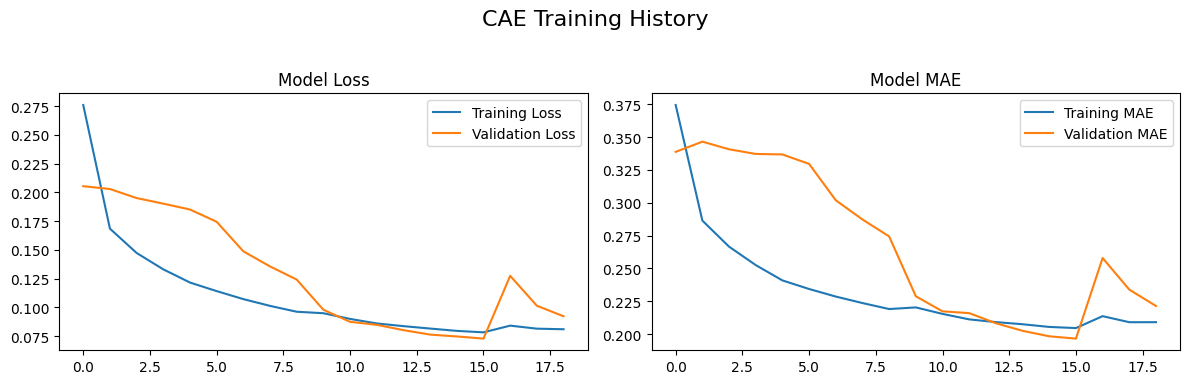

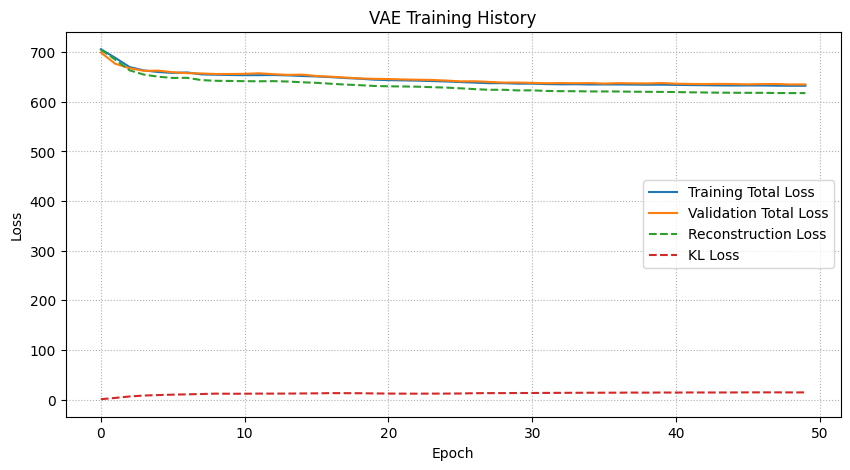

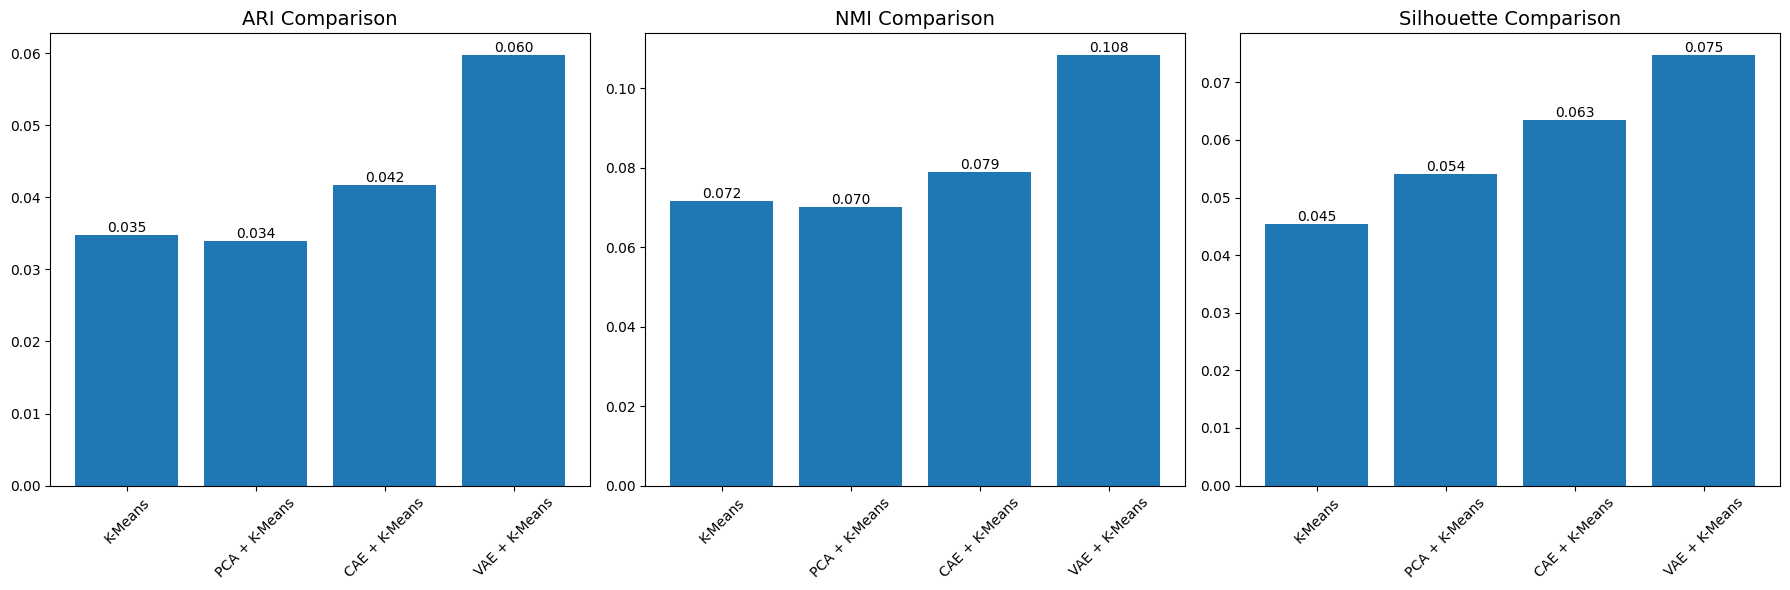

Applying t-SNE for pca embeddings...
Applying t-SNE for cae embeddings...
Applying t-SNE for vae embeddings...


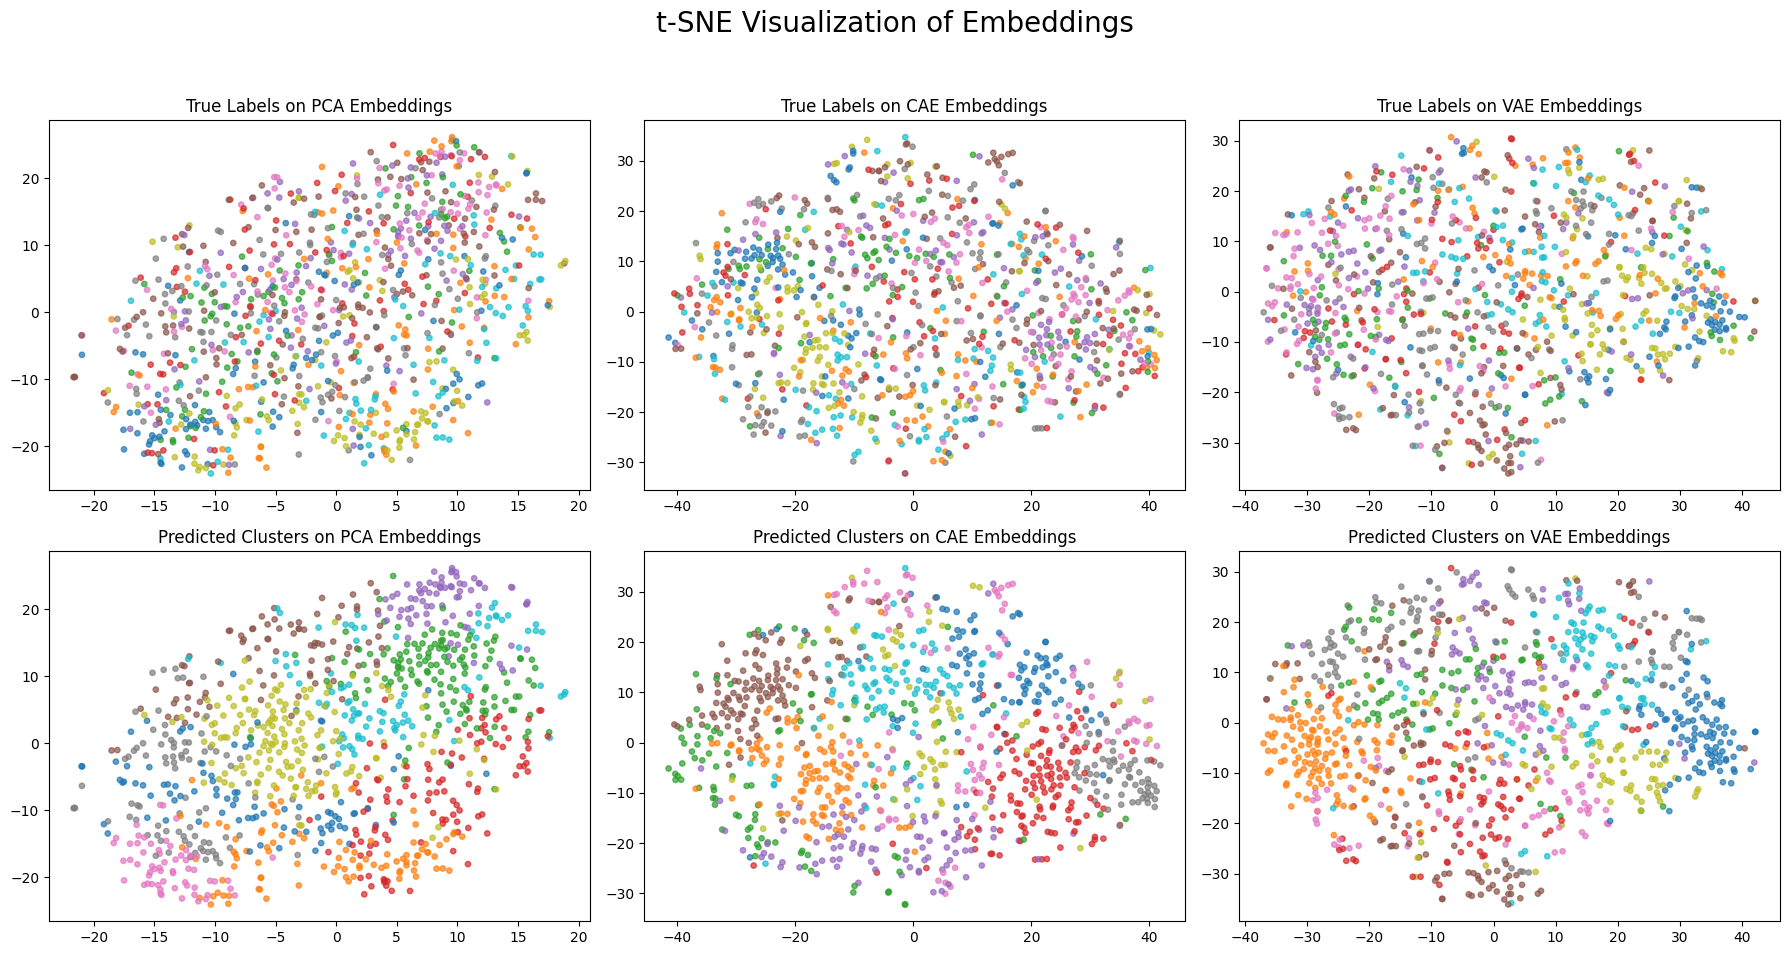


=== PROJECT COMPLETED ===


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
import os

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Global configuration
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()

    def load_cifar10(self, subset_size=10000):
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()

        # Combine and take a subset
        x_data = np.concatenate([x_train, x_test], axis=0)
        y_data = np.concatenate([y_train, y_test], axis=0)
        indices = np.random.choice(len(x_data), subset_size, replace=False)
        x_data = x_data[indices]
        y_data = y_data[indices].flatten()

        # Normalization for AE/VAE
        x_data_normalized = x_data.astype('float32') / 255.0
        x_data_cae = (x_data_normalized - 0.5) * 2.0  # Scale to [-1, 1] for CAE

        # Normalize and flatten for traditional methods
        x_flat = x_data_normalized.reshape(len(x_data_normalized), -1)
        x_flat = self.scaler.fit_transform(x_flat)

        return x_data_normalized, x_data_cae, x_flat, y_data

# ---------------------------------------------------------------------------- #
# VAE
# ---------------------------------------------------------------------------- #

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent vector."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    """Variational Autoencoder (VAE) model."""
    def __init__(self, input_shape, latent_dim=256, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder(input_shape, latent_dim)
        self.decoder = self.build_decoder(latent_dim)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def build_encoder(self, input_shape, latent_dim):
        encoder_inputs = keras.Input(shape=input_shape)
        x = layers.Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, (3, 3), activation="relu", strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(256, (3, 3), activation="relu", strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Flatten()(x)
        x = layers.Dense(512, activation="relu")(x)

        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])

        return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    def build_decoder(self, latent_dim):
        latent_inputs = keras.Input(shape=(latent_dim,))
        x = layers.Dense(4 * 4 * 256, activation="relu")(latent_inputs)
        x = layers.Reshape((4, 4, 256))(x)
        x = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        decoder_outputs = layers.Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)
        return keras.Model(latent_inputs, decoder_outputs, name="decoder")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        # FIX: The input `data` is just x, not a tuple of (x, y)
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2))
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# ---------------------------------------------------------------------------- #
# CAE MODEL
# ---------------------------------------------------------------------------- #
def create_enhanced_cae_model(input_shape, latent_dim=256):
    """Creates an enhanced Convolutional Autoencoder with better architecture."""
    encoder_inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(0.2)(x)
    shape_before_flattening = x.shape[1:]
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    latent = layers.Dense(latent_dim, activation='linear', kernel_regularizer=regularizers.l2(1e-4), name='latent_space')(x)
    encoder = Model(encoder_inputs, latent, name='encoder')
    latent_inputs = keras.Input(shape=(latent_dim,))
    flat_size = np.prod(shape_before_flattening)
    x_dec = layers.Dense(512, activation='relu')(latent_inputs)
    x_dec = layers.BatchNormalization()(x_dec)
    x_dec = layers.Dropout(0.3)(x_dec)
    x_dec = layers.Dense(flat_size, activation='relu')(x_dec)
    x_dec = layers.Reshape(shape_before_flattening)(x_dec)
    x_dec = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x_dec)
    x_dec = layers.BatchNormalization()(x_dec)
    x_dec = layers.UpSampling2D((2, 2))(x_dec)
    x_dec = layers.Dropout(0.2)(x_dec)
    x_dec = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x_dec)
    x_dec = layers.BatchNormalization()(x_dec)
    x_dec = layers.UpSampling2D((2, 2))(x_dec)
    x_dec = layers.Dropout(0.1)(x_dec)
    x_dec = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x_dec)
    x_dec = layers.BatchNormalization()(x_dec)
    x_dec = layers.UpSampling2D((2, 2))(x_dec)
    x_dec = layers.Dropout(0.1)(x_dec)
    decoder_outputs = layers.Conv2DTranspose(3, (3, 3), activation='tanh', padding='same')(x_dec)
    decoder = Model(latent_inputs, decoder_outputs, name='decoder')
    outputs = decoder(encoder(encoder_inputs))
    cae_model = keras.Model(encoder_inputs, outputs, name='enhanced_cae')
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)
    cae_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return cae_model, encoder

class DeepClusteringModel:
    """Deep clustering model that combines CAE with clustering."""
    def __init__(self, input_shape, n_clusters, latent_dim=256):
        self.cae_model, self.encoder = create_enhanced_cae_model(input_shape, latent_dim)
        self.n_clusters = n_clusters

    def pretrain_autoencoder(self, X, epochs=50, batch_size=128):
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        ]
        print("Pretraining Convolutional Autoencoder (Deterministic)...")
        history = self.cae_model.fit(
            X, X, epochs=epochs, batch_size=batch_size, validation_split=0.15,
            callbacks=callbacks, verbose=1, shuffle=True
        )
        return history

    def get_embeddings(self, X):
        embeddings = self.encoder.predict(X, batch_size=256, verbose=0)
        embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
        return embeddings

    def cluster_embeddings(self, embeddings, n_init=20):
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=n_init)
        labels = kmeans.fit_predict(embeddings)
        return labels, kmeans.cluster_centers_

class ClusteringEvaluator:
    """Evaluates and compares clustering methods."""
    def __init__(self):
        self.results = {}

    def evaluate_clustering(self, X, y_true, y_pred, method_name):
        ari = adjusted_rand_score(y_true, y_pred)
        nmi = normalized_mutual_info_score(y_true, y_pred)
        silhouette = silhouette_score(X, y_pred) if len(np.unique(y_pred)) > 1 else -1
        self.results[method_name] = {'ARI': ari, 'NMI': nmi, 'Silhouette': silhouette}
        print(f"{method_name} Results:")
        print(f"  Adjusted Rand Index: {ari:.3f}")
        print(f"  Normalized Mutual Info: {nmi:.3f}")
        print(f"  Silhouette Score: {silhouette:.3f}\n")

    def compare_methods(self, X_vae, X_cae, X_flat, y_true, n_clusters=10, epochs=50):
        """Compares traditional and neural network methods, including VAE."""
        print("=== TRADITIONAL CLUSTERING METHODS ===\n")
        # K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        y_kmeans = kmeans.fit_predict(X_flat)
        self.evaluate_clustering(X_flat, y_true, y_kmeans, "K-Means")

        # PCA + K-Means
        pca = PCA(n_components=100, random_state=42)
        X_pca = pca.fit_transform(X_flat)
        kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        y_pca_kmeans = kmeans_pca.fit_predict(X_pca)
        self.evaluate_clustering(X_pca, y_true, y_pca_kmeans, "PCA + K-Means")

        print("\n=== DETERMINISTIC NEURAL NETWORK (CAE) ===\n")
        deep_clustering_cae = DeepClusteringModel(
            input_shape=X_cae.shape[1:], n_clusters=n_clusters, latent_dim=256
        )
        history_cae = deep_clustering_cae.pretrain_autoencoder(X_cae, epochs=epochs, batch_size=128)
        X_cae_embed = deep_clustering_cae.get_embeddings(X_cae)
        y_cae_kmeans, _ = deep_clustering_cae.cluster_embeddings(X_cae_embed)
        self.evaluate_clustering(X_cae_embed, y_true, y_cae_kmeans, "CAE + K-Means")

        print("\n=== NON-DETERMINISTIC NEURAL NETWORK (VAE) ===\n")
        vae = VAE(input_shape=X_vae.shape[1:], latent_dim=256)
        vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
        print("Pretraining Variational Autoencoder (Non-Deterministic)...")
        history_vae = vae.fit(X_vae, epochs=epochs, batch_size=128, validation_split=0.15, verbose=1)

        z_mean, _, _ = vae.encoder.predict(X_vae, batch_size=256)
        X_vae_embed = z_mean / (np.linalg.norm(z_mean, axis=1, keepdims=True) + 1e-8)

        kmeans_vae = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
        y_vae_kmeans = kmeans_vae.fit_predict(X_vae_embed)
        self.evaluate_clustering(X_vae_embed, y_true, y_vae_kmeans, "VAE + K-Means")

        self.plot_training_history(history_cae, "CAE Training History")
        self.plot_training_history_vae(history_vae, "VAE Training History")

        return {
            'predictions': {
                'kmeans': y_kmeans, 'pca_kmeans': y_pca_kmeans,
                'cae_kmeans': y_cae_kmeans, 'vae_kmeans': y_vae_kmeans
            },
            'embeddings': {
                'pca': X_pca, 'cae': X_cae_embed, 'vae': X_vae_embed
            }
        }

    def plot_training_history(self, history, title):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(title, fontsize=16)
        axes[0].plot(history.history['loss'], label='Training Loss')
        axes[0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0].set_title('Model Loss')
        axes[0].legend()
        axes[1].plot(history.history['mae'], label='Training MAE')
        axes[1].plot(history.history['val_mae'], label='Validation MAE')
        axes[1].set_title('Model MAE')
        axes[1].legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def plot_training_history_vae(self, history, title):
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['total_loss'], label='Training Total Loss')
        plt.plot(history.history['val_total_loss'], label='Validation Total Loss')
        plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss', linestyle='--')
        plt.plot(history.history['kl_loss'], label='KL Loss', linestyle='--')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle=':')
        plt.show()

    def plot_results(self):
        if not self.results: return
        methods = list(self.results.keys())
        metrics = ['ARI', 'NMI', 'Silhouette']
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        for i, metric in enumerate(metrics):
            values = [self.results[method][metric] for method in methods]
            bars = axes[i].bar(methods, values)
            axes[i].set_title(f'{metric} Comparison', fontsize=14)
            axes[i].tick_params(axis='x', rotation=45, labelsize=10)
            for bar in bars:
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width() / 2., height, f'{height:.3f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

    def visualize_clusters(self, embeddings, y_true, predictions, max_samples=1000):
        indices = np.random.choice(len(y_true), min(len(y_true), max_samples), replace=False)
        y_true_vis = y_true[indices]

        methods = list(embeddings.keys())
        num_methods = len(methods)
        fig, axes = plt.subplots(2, num_methods, figsize=(6 * num_methods, 10), squeeze=False)
        fig.suptitle('t-SNE Visualization of Embeddings', fontsize=20)

        for i, method in enumerate(methods):
            embed = embeddings[method]
            print(f"Applying t-SNE for {method} embeddings...")
            tsne = TSNE(n_components=2, random_state=42)
            embed_vis = embed[indices]
            X_tsne = tsne.fit_transform(embed_vis)

            # Plot true labels
            ax_true = axes[0, i]
            ax_true.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_true_vis, cmap='tab10', s=15, alpha=0.7)
            ax_true.set_title(f'True Labels on {method.upper()} Embeddings')

            # Plot predicted labels
            ax_pred = axes[1, i]
            pred_vis = predictions[f'{method}_kmeans'][indices]
            ax_pred.scatter(X_tsne[:, 0], X_tsne[:, 1], c=pred_vis, cmap='tab10', s=15, alpha=0.7)
            ax_pred.set_title(f'Predicted Clusters on {method.upper()} Embeddings')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def main():
    print("=== DEEP CLUSTERING PROJECT (CAE vs VAE) ===\n")
    preprocessor = DataPreprocessor()
    evaluator = ClusteringEvaluator()

    print("=== LOADING CIFAR-10 DATA ===\n")
    X_vae, X_cae, X_flat, y_true = preprocessor.load_cifar10(subset_size=5000)
    print(f"VAE/Flat data shape: {X_vae.shape}")
    print(f"CAE data shape: {X_cae.shape}")
    print(f"Number of classes: {len(np.unique(y_true))}\n")

    results = evaluator.compare_methods(X_vae, X_cae, X_flat, y_true, n_clusters=10)

    evaluator.plot_results()
    evaluator.visualize_clusters(results['embeddings'], y_true, results['predictions'], max_samples=1000)

    print("\n=== PROJECT COMPLETED ===")

if __name__ == "__main__":
    main()


In [ ]:
# ARI: This metric measures the similarity between your predicted clusters and the true class labels, correcting for random chance. A score of 1.0 indicates a perfect clustering, while a score of 0.0 or less indicates a random clustering.
# NMI: Measures the agreement between the predicted clusters and true labels, normalizing the score so that it ranges from 0.0 (no mutual information) to 1.0 (perfect correlation). Higher scores are better.
# Silhouette: : This metric measures how well each data point fits into its assigned cluster.A score close to +1 indicates that the data point is well-matched to its own cluster and poorly matched to neighboring clusters.